In [1]:
import numpy as np
import librosa
import math
from playsound import playsound
import matplotlib.pyplot as plt
import librosa.display

In [12]:
# test .wav can playsound
filename = '2.wav'
playsound(filename)
y, sr = librosa.load(filename, sr=None)
y = y/max(abs(y))

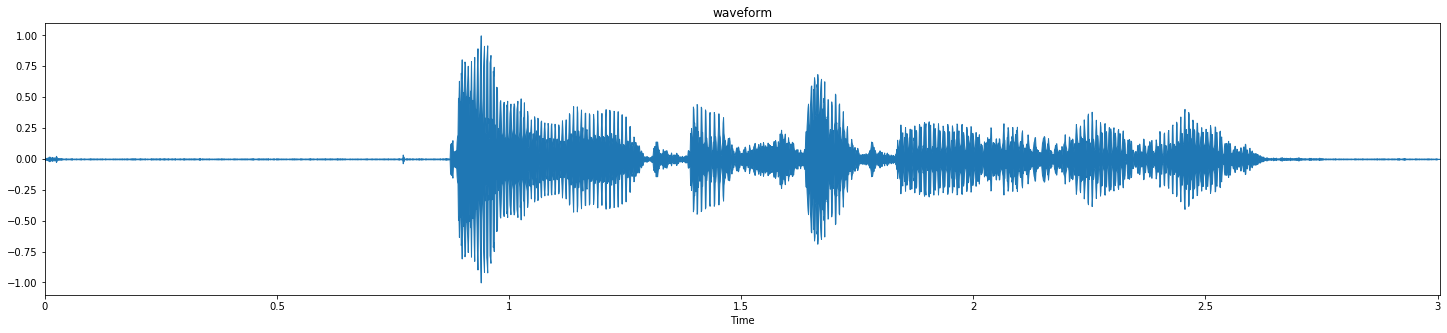

In [13]:
plt.figure(figsize=(25, 5))
librosa.display.waveplot(y, sr=sr)
plt.title('waveform')
plt.show()

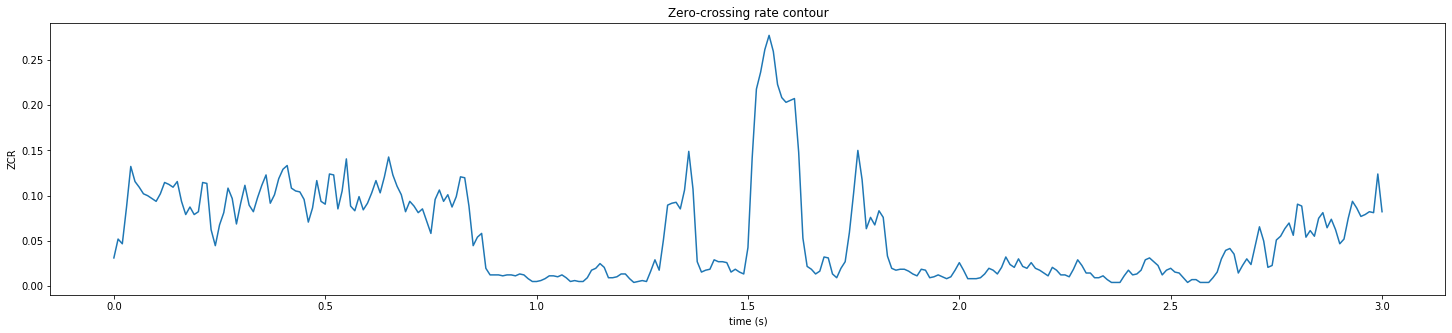

In [14]:
# w(n) = 1/(2*N) if 0~N-1 else 0
def sgn(arr):
    for i in range(len(arr)):
        if(arr[i]>=0):
            arr[i] = 1
        else:
            arr[i] = -1
    return arr
def calZcr(waveData,frameSize,overLap):
    wlen = len(waveData)
    frameShift = frameSize - overLap
    frameNum = math.ceil(wlen/frameShift)
    zcr = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*frameShift,min(i*frameShift+frameSize,wlen))]
        curFrame = sgn(curFrame)
        zcr[i] = sum(abs(curFrame[1:] - curFrame[:-1]))/(2*frameSize)
    return zcr

# print(len(y))
# 20ms
frameSize = int(0.02*sr)
# print(sr)
# print(frameSize)
overLap = int(frameSize/2)
zcr = calZcr(y,frameSize,overLap)

# print(len(zcr))
time_zcr = np.arange(0, len(zcr)) * 0.02 * ((frameSize-overLap)/frameSize)
plt.figure(figsize=(25, 5))
plt.plot(time_zcr, zcr)
plt.ylabel("ZCR")
plt.xlabel("time (s)")
plt.title('Zero-crossing rate contour')
plt.show()

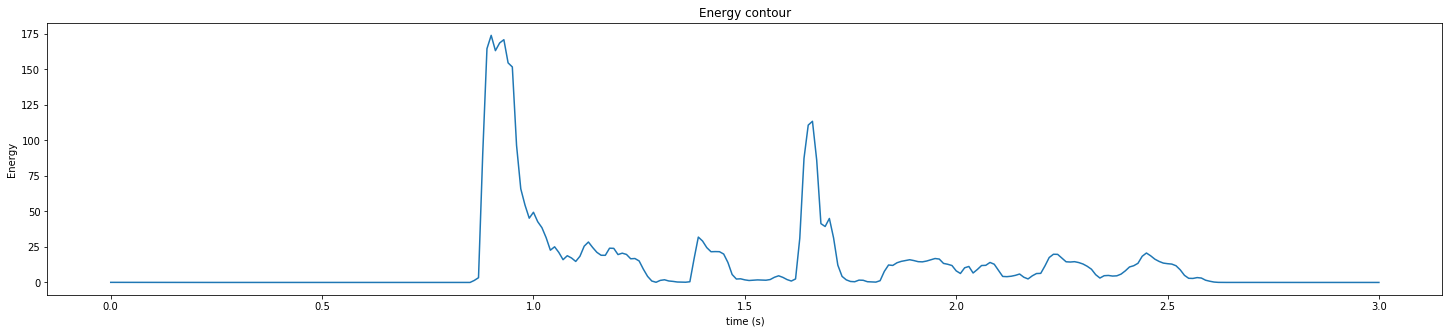

In [15]:
# w(n) = rectangular window 1 if 0~N-1 else 0
def calEnergy(waveData,frameSize,overLap):
    wlen = len(waveData)
    frameShift = frameSize - overLap
    frameNum = math.ceil(wlen/frameShift)
    energy = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*frameShift,min(i*frameShift+frameSize,wlen))]
        energy[i] = sum(curFrame**2)
    return energy

frameSize = int(0.02*sr)
overLap = int(frameSize/2)
energy = calEnergy(y,frameSize,overLap)

# print(len(zcr))
time_energy = np.arange(0, len(energy)) * 0.02 * ((frameSize-overLap)/frameSize)
plt.figure(figsize=(25, 5))
plt.plot(time_energy, energy)
plt.ylabel("Energy")
plt.xlabel("time (s)")
plt.title('Energy contour')
plt.show()

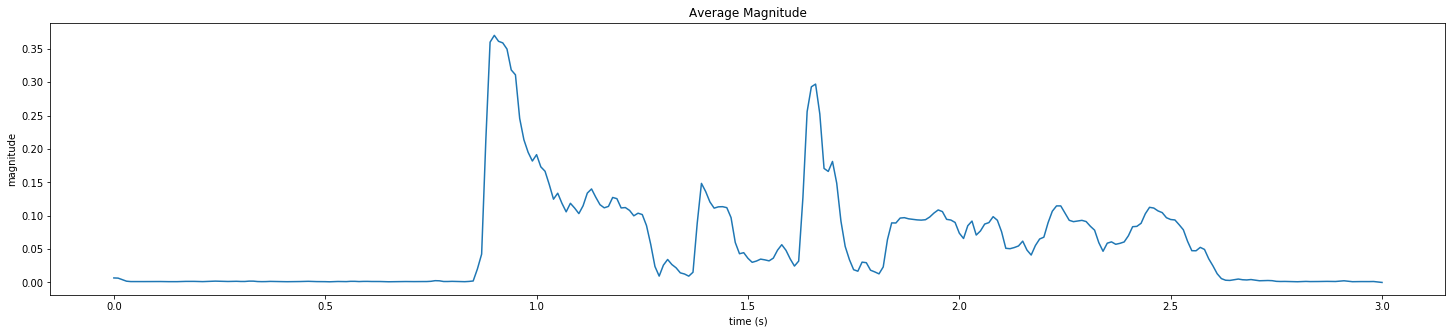

In [16]:
# w(n) = 1/(N) if 0~N-1 else 0
def calMagnitude(waveData,frameSize,overLap):
    wlen = len(waveData)
    frameShift = frameSize - overLap
    frameNum = math.ceil(wlen/frameShift)
    magnitude = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*frameShift,min(i*frameShift+frameSize,wlen))]
        magnitude[i] = sum(abs(curFrame))/(frameSize)
    return magnitude

frameSize = int(0.02*sr)
overLap = int(frameSize/2)
magnitude = calMagnitude(y,frameSize,overLap)
time_magnitude = np.arange(0, len(magnitude)) * 0.02 * ((frameSize-overLap)/frameSize)
plt.figure(figsize=(25, 5))
plt.plot(time_magnitude, magnitude)
plt.ylabel("magnitude")
plt.xlabel("time (s)")
plt.title('Average Magnitude')
plt.show()

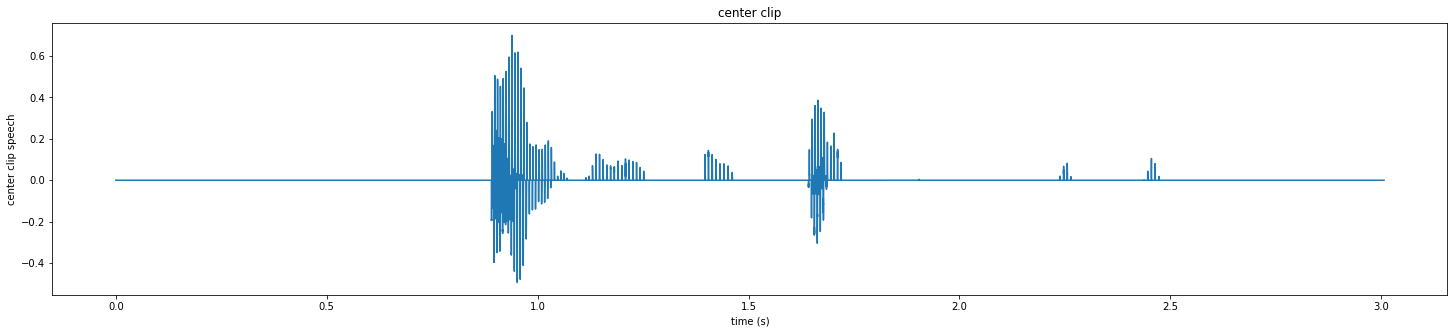

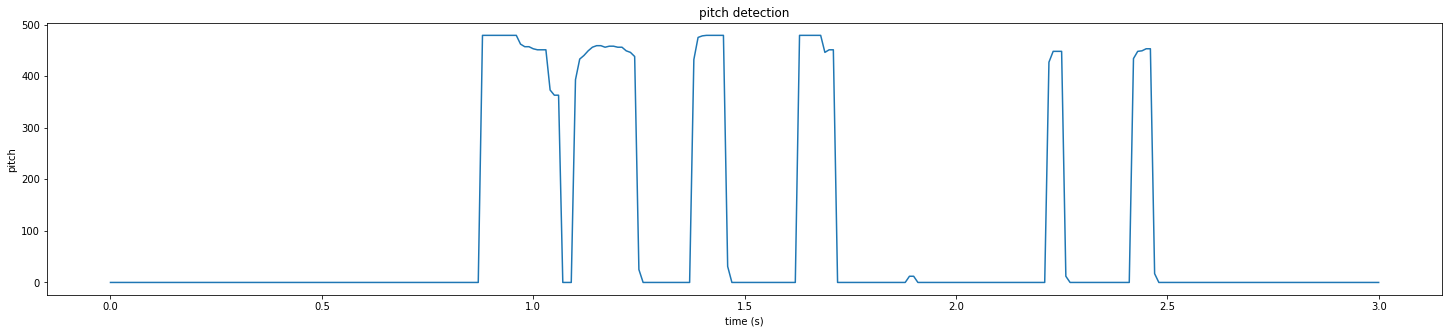

In [17]:
# center clip
CL = 0.3*np.max(abs(y.copy()))
x = np.zeros((len(y),1))
for i in range(len(y)):
    if y[i]>=CL:
        x[i] = y[i]-CL
    elif abs(y[i])<CL:
        x[i] = 0
    else:
        x[i] = y[i]+CL
time_center_clip = np.arange(0,len(x))/sr
plt.figure(figsize=(25, 5))
plt.plot(time_center_clip, x)
plt.ylabel("center clip speech")
plt.xlabel("time (s)")
plt.title('center clip')
plt.show()

# calculate Rn(k) use autocorrelation
def calPitch(waveData,frameSize,overLap):
    R = 0
    Rn = 0
    maxk = 0
    frameShift = frameSize - overLap
    wlen = len(waveData)
    frameNum = math.ceil(wlen/frameShift)
    R = np.zeros((frameNum,1))
    for i in range(frameNum):
        for k in range(frameShift):
            Rn = np.zeros((frameShift,1))
            if i*frameShift+frameSize+k<wlen:
                curFrame = x[np.arange(i*frameShift,min(i*frameShift+frameSize,wlen))]
                nxtFrame = x[np.arange(i*frameShift+k,min(i*frameShift+frameSize+k,wlen))]
                Rn[k] = sum(curFrame*nxtFrame)
                if abs(Rn[k])>abs(Rn[maxk]):
                    maxk = k
        R[i] = maxk
        maxk = 0
    return R

frameSize = int(0.02*sr)
overLap = int(frameSize/2)
pitch = calPitch(x,frameSize,overLap)
time_pitch = np.arange(0, len(pitch)) * 0.02 * ((frameSize-overLap)/frameSize)
plt.figure(figsize=(25, 5))
plt.plot(time_pitch, pitch)
plt.ylabel("pitch")
plt.xlabel("time (s)")
plt.title('pitch detection')
plt.show()

[83]
[278]



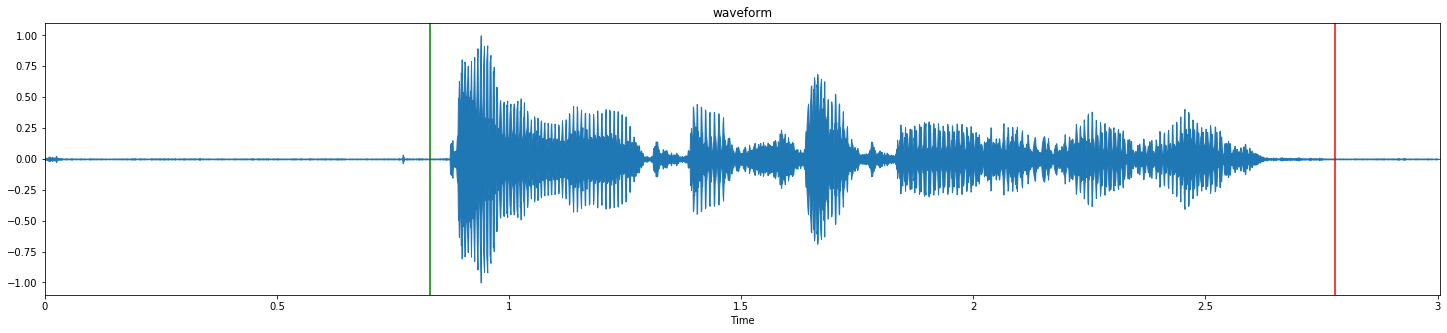

In [11]:
def findThreshold(zcr,magnitude):
    # find IZCT
    IF = 25
    zcr_copy = zcr[:10].copy()
    zcr_mean = np.mean(zcr_copy)
    zcr_std = np.std(zcr_copy)
    IZCT = min(IF, zcr_mean+2*zcr_std)
    # find ITL ITU
    magnitude_copy = magnitude[:10].copy()
    IMX = np.max(magnitude_copy)
    IMN = np.min(magnitude_copy)
    I1 = 0.03*(IMX-IMN)+IMN
    I2 = 4*IMN
    ITL = min(I1,I2)
    ITU = 5*ITL
    return IZCT,ITL,ITU

def end_point_detection(IZCT,ITL,ITU,magnitude,zcr):
    ITU_index = np.where((magnitude>ITU))[0]
    ITL_index = np.where((magnitude<=ITL))[0]
    IZCT_index = np.where((zcr<=IZCT))[0]
#     print(ITU_index)
#     print(ITL_index)
#     print(IZCT_index)
    start = []
    end = []
    for i in ITU_index:
        N1 = ITL_index[np.where((ITL_index<i))[0][-1]]
        if (N1-IZCT_index[np.where((IZCT_index<N1))[0][-1]])>=3:
            N1 = IZCT_index[np.where((IZCT_index<N1))[0][-1]]
        if len(start)!=0 and len(end)!=0:
            if N1>int(end[-1]):
                start.append(N1)
        else:
            start.append(N1)
        N2 = ITL_index[np.where((ITL_index>i))[0][0]]
        if (N2-IZCT_index[np.where((IZCT_index>N2))[0][0]])>=3:
            N2 = IZCT_index[np.where((IZCT_index>N2))[0][0]]
        if len(start)-len(end)==1:
            end.append(N2)    
    return start,end

IZCT,ITL,ITU = findThreshold(zcr,magnitude)
start, end = end_point_detection(IZCT,ITL,ITU,magnitude,zcr)
print(start)
print(end)
plt.figure(figsize=(25, 5))
librosa.display.waveplot(y, sr=sr)
plt.title('waveform')
print()
for s, e in zip(start, end):
    plt.axvline(x=s*0.02*((frameSize-overLap)/frameSize), color='green') 
    plt.axvline(x=e*0.02*((frameSize-overLap)/frameSize), color='red')
plt.show()